In [1]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import numpy as np
import random
import math

This notebook demonstrates a couple of simple functions for putting blobs into thermal images.

Firstly, there's some code to place a blob (i.e. a 2D array of values) into an image. This function is slighlty more complicated than it could be because we need to handle the case when we want to paste something near the edge of an image (we can't guarantee that animals will always be perfectly in shot!) But the cheat way to do this is pad the image so we don't go out of bounds, then place the object, and then crop back to the original size.

In [2]:
def place_object(image, obj, loc_x=-1, loc_y=-1, allow_crop=True, noise=True, noise_amp=0.1):
    """
    Places obj into image, in a random location. Optionally adds Poisson
    (shot) noise.
    
    Parameters
    ----------
        image : np.array
            input (base) image
        obj : np.array
            object to place
        allow_crop : bool
            whether to allow partial placements (e.g. near edges)
        noise : bool
            add Poisson noise
        noise_amp : float
            noise amplitude

    Returns
    -------
        np.array
            image with object added
        tuple
            coordinates of object

    """
    
    height, width = image.shape
    o_height, o_width = obj.shape
    
    if loc_x == -1 and loc_y == -1:
        if allow_crop:
            loc_x = random.randint(0, width-1)
            loc_y = random.randint(0, height-1)
        else:
            loc_x = random.randint(o_width/2, width-1-o_width/2)
            loc_y = random.randint(o_height/2, height-1-o_height/2)
        
    pad_x = math.ceil(o_width/2)
    pad_y = math.ceil(o_height/2)
    
    loc_x += pad_x
    loc_y += pad_y

    image_pad = np.zeros((height+2*pad_y, width+2*pad_x))
    image_pad[pad_y:-pad_y, pad_x:-pad_x] = image

    lim_left = int(loc_x-o_width/2)
    lim_right = int(loc_x+o_width/2)

    lim_top = int(loc_y-o_height/2)
    lim_bottom = int(loc_y+o_height/2)
    
    if noise:
        obj += noise_amp*np.random.poisson(0.1, size=obj.shape)
    
    image_pad[lim_top:lim_bottom,lim_left:lim_right] += obj
            
    return image_pad[pad_y:-pad_y, pad_x:-pad_x], (loc_x-pad_x, loc_y-pad_y)

Next we can try some simple Gaussians:

In [3]:
def Gauss2D(x, y, amplitude, xo, yo, sigma_x, sigma_y, theta, offset = 0):
    """
    Returns the amplitude of the given Gaussian distribution at (x, y)
    
    Parameters
    ----------
    
        x : float
        y : float
            coordinates
        amplitude:
            height of peak
        xo : float
        yo : float
            centre of peak (mean)
        sigma_x : float
        sigma_y : float
            x and y spread (standard dev)
        theta : float
            rotation (radians)
        offset : float
            additive offset (background level)
    Returns
    -------
    
        float
            amplitude at (x, y)
            
    """
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

def gaussian(size=9, amplitude=1, sigma_x=2, sigma_y=2, theta=0, offset=0, xo=0, yo=0):
    """
    Makes a 2D array and fills it with values from above.
    
    This is inefficient, we should probably vectorise this code.
    
    Parameters
    ----------
        size : int
            height/width of output
        see `gaussian` for other parameters
    
    Returns
    -------
        np.array
            generated Gaussian
    
    """
    
    
    if size % 2:
        size += 1
    
    blob = np.zeros((size, size))
    
    coords = np.linspace(-size/2, size/2, size)
    
    for xi, x in enumerate(coords):
        for yi, y in enumerate(coords):
            blob[yi, xi] = Gauss2D(x, y, amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
            
    return blob

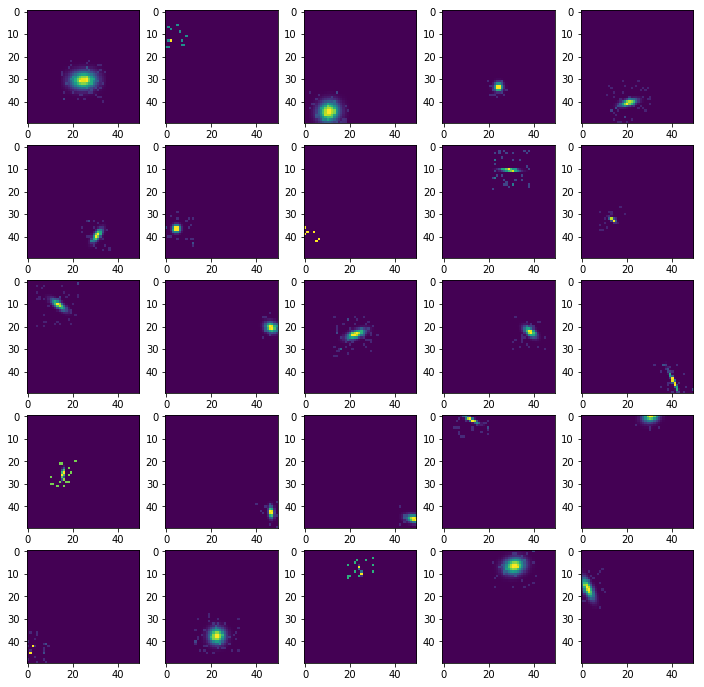

In [4]:
plt.figure(figsize=(12,12))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    
    obj_size = random.randint(10,20)
    
    obj = gaussian(size=obj_size,
                   sigma_x=random.random()*obj_size/5.0,
                   sigma_y=random.random()*obj_size/5.0,
                   theta=math.pi*random.random())
    image = np.zeros((50,50))
    ax.imshow(place_object(image, obj)[0])

We can also be a bit more clever and generate skewed distributions:

In [5]:
def skew_gaussian(size=9, amp_mu=5, amp_std=2, skew_x=3, skew_y=3):
    """
    Generate a random skewed 2D Gaussian. This code uses the dot product of
    two skew normal distributions which is probably not statistically
    meaningful, but it's a cheap way of generating skewed distributions.
    
    
    Parameters
    ----------
        size : int
            output size, should be odd
        amp_mu : float
            output amplitude mean
        amp_std : np.array
            output amplitude stdev
        skew_x:
            max skew to generate in x
        skew_y:
            max skew to generate in y
    Returns
    -------
        np.array
            generated distribution

    """
    
    if not size % 2:
        raise ValueError("Size must be odd!")
    
    # Generate 2 1D distributions
    a = -skew_x/2+skew_x*random.random()
    b = -skew_y/2+skew_y*random.random()

    # Size of blob
    x = np.linspace(-0.8*max(skew_x, skew_y),0.8*max(skew_x, skew_y), size)
    
    # Generate a 2D skewed distribution
    blob = np.dot(skewnorm.pdf(x, a).reshape((-1,1)),  skewnorm.pdf(x, b).reshape((1,-1)))
            
    # Normalise
    blob /= np.max(blob)
    
    # Scale by random amplitude
    amp = np.random.normal(amp_mu, amp_std)
    blob *= amp*(1.0/np.max(blob))
    
    return blob

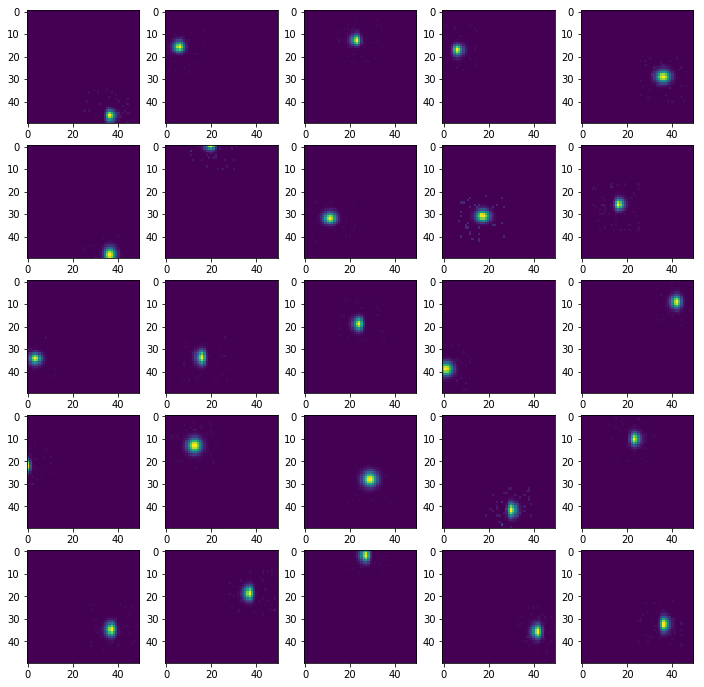

In [6]:
plt.figure(figsize=(12,12))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    
    obj = skew_gaussian(size=21, skew_x=3, skew_y=6)
    image = np.zeros((50,50))
    ax.imshow(place_object(image, obj)[0])

And applied to a test image:

In [7]:
import cv2

image = cv2.imread("./example_radiometric.tiff", cv2.IMREAD_UNCHANGED)

Note that we use `cv2.IMREAD_UNCHANGED` to ensure that we load the image raw, otherwise OpenCV will convert it to 8-bit silently.

Plotting the image with a colormap shows that we've got the correct range (e.g. 16-bit intensities):

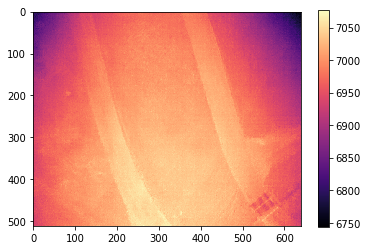

In [8]:
plt.imshow(image, cmap='magma')
plt.colorbar()

Let's insert some animals.

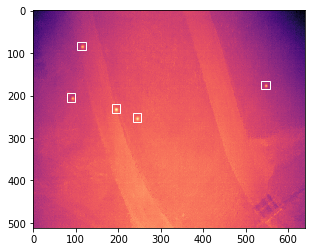

In [9]:
object_size = 15

plt.figure()

# Make a copy of the image
augmented = np.array(image)

for i in range(5):
    # Place an animal
    obj = skew_gaussian(size=object_size, skew_x=1, skew_y=3, amp_mu=140)
    augmented, coord = place_object(augmented, obj)

    # Plot a box (TODO: figure out what's up with these coords)
    x, y = coord
    x -= object_size/4
    y -= object_size/4
    plt.gca().add_patch(plt.Polygon([(x-object_size/1.5, y-object_size/1.5),
                                     (x-object_size/1.5, y+object_size/1.5),
                                     (x+object_size/1.5, y+object_size/1.5),
                                     (x+object_size/1.5, y-object_size/1.5)], fill=False, color='white'))#

plt.imshow(augmented, cmap='magma')

Does this look realistic? Compare to an actual frame from a "baboon" flight and be the judge:

In [15]:
image = cv2.imread("./baboons.jpg", cv2.IMREAD_UNCHANGED)

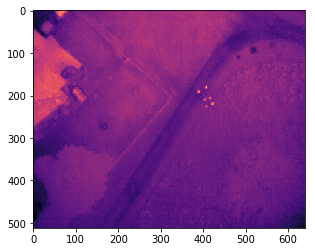

In [16]:
plt.imshow(image, cmap='magma')

Hmm looks similar, but those animals are _clustered_. Can we do similar?

Sure - we can generate some randomly distributed points. How about placing 7 monkeys in a group in the same image:

In [17]:
centre_x = 300
centre_y = 400

x_locs = np.random.normal(loc=centre_x, scale=20, size=7)
y_locs = np.random.normal(loc=centre_y, scale=20, size=7)

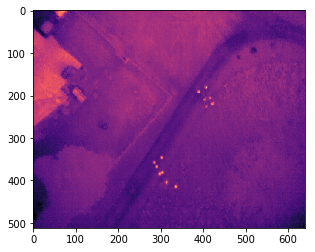

In [18]:
plt.figure()

# Make a copy of the image
augmented = np.array(image)

for x, y in list(zip(x_locs, y_locs)):
    
    object_size = 13
    # Place an animal
    obj = skew_gaussian(size=object_size, skew_x=1, skew_y=3, amp_mu=140)
    augmented, coord = place_object(augmented, obj, loc_x=x, loc_y=y)

    plt.imshow(augmented, cmap='magma')

Have fun!